## Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## Path

In [3]:
base_path = "/kaggle/input/image-and-video/caltech-101/101_ObjectCategories/101_ObjectCategories"


## Random Images Visualization

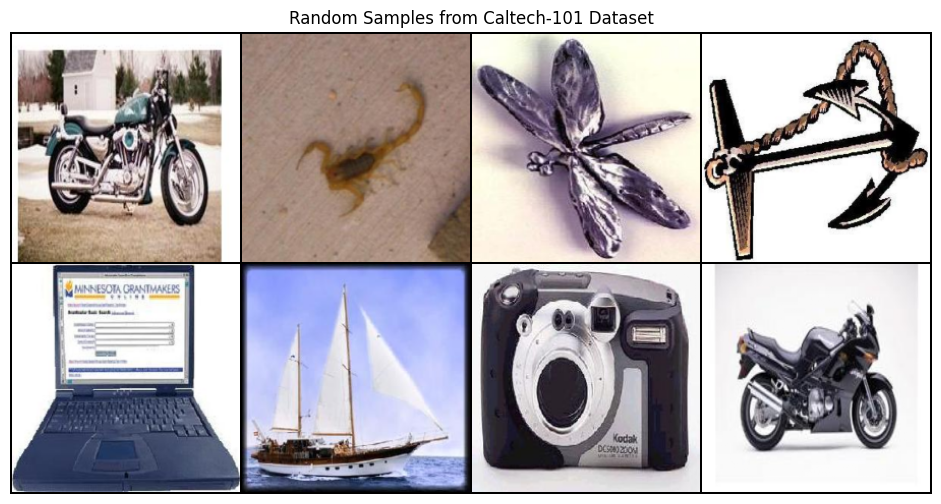

Labels: ['Motorbikes', 'scorpion', 'dragonfly', 'anchor', 'laptop', 'ketch', 'camera', 'Motorbikes']


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Load dataset only once
from torchvision import datasets, transforms

base_path = "/kaggle/input/image-and-video/caltech-101/101_ObjectCategories/101_ObjectCategories"

transform_vis = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_vis = datasets.ImageFolder(base_path, transform=transform_vis)

# Random sample image grid
def visualize_samples():
    indices = np.random.choice(len(dataset_vis), 8, replace=False)
    images = [dataset_vis[i][0] for i in indices]
    labels = [dataset_vis.classes[dataset_vis[i][1]] for i in indices]

    grid = make_grid(images, nrow=4)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("Random Samples from Caltech-101 Dataset")
    plt.axis("off")
    plt.show()

    print("Labels:", labels)

visualize_samples()


## Class Distribution Chart

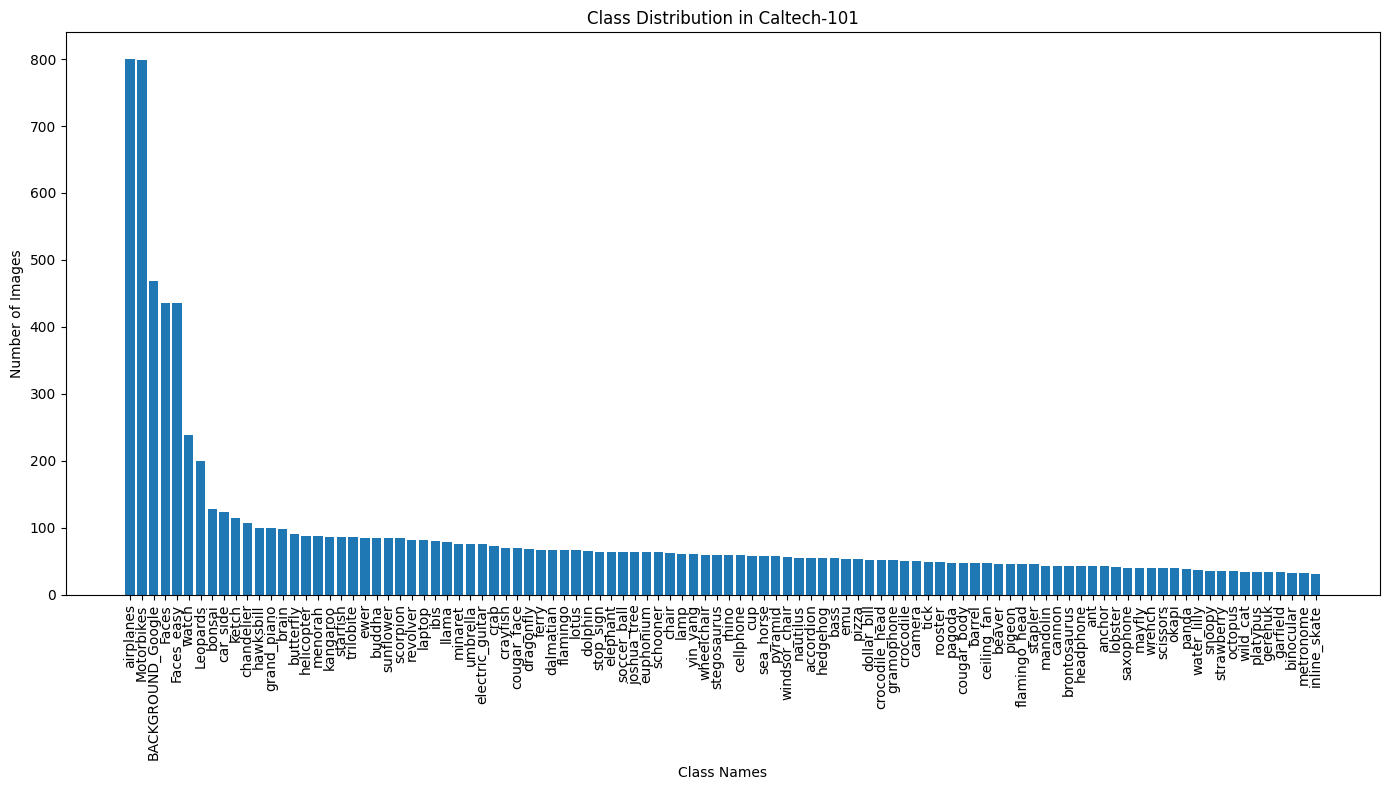

In [10]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort classes by count
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 8))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in Caltech-101")
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


## Data Augmentation + Preprocessing

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Image Augmentation Visualization

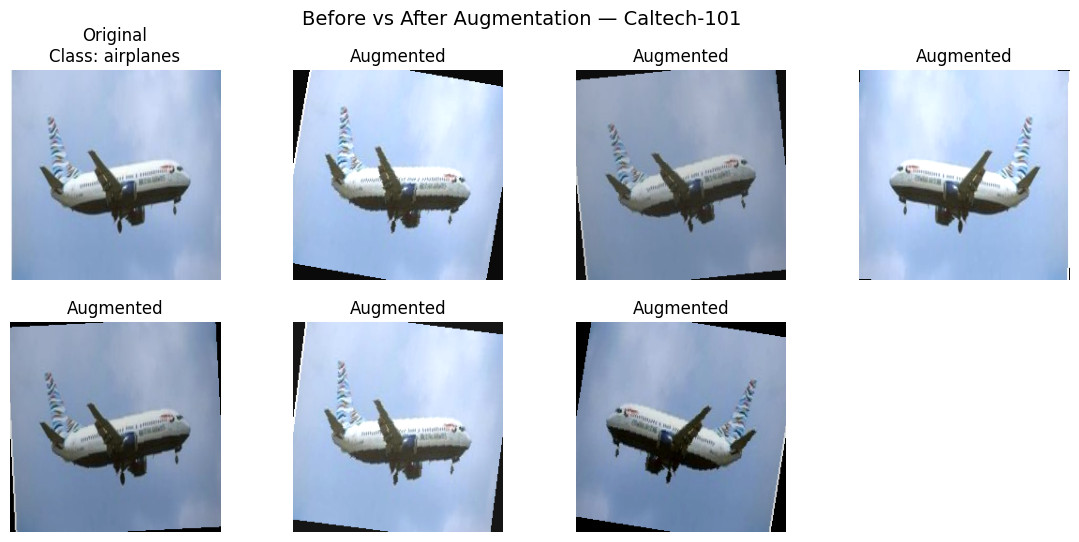

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
import random

# Dataset Path
base_path = "/kaggle/input/image-and-video/caltech-101/101_ObjectCategories/101_ObjectCategories"

# Augmentation transform (same as training)
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Original transform (for Before image)
orig_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset for visualization
dataset = datasets.ImageFolder(base_path)

# Select a random image
idx = random.randint(0, len(dataset) - 1)
img_path, label = dataset.samples[idx]
original_img = Image.open(img_path).convert("RGB")

# Plot Original + Augmented images
plt.figure(figsize=(14, 6))

# Original
orig_img_tensor = orig_transform(original_img)
plt.subplot(2, 4, 1)
plt.imshow(np.transpose(orig_img_tensor.numpy(), (1, 2, 0)))
plt.title(f"Original\nClass: {dataset.classes[label]}")
plt.axis("off")

# Augmented versions
for i in range(6):
    aug_img_tensor = augment_transform(original_img)
    plt.subplot(2, 4, i + 2)
    img_np = np.transpose(aug_img_tensor.numpy(), (1, 2, 0))
    plt.imshow(img_np)
    plt.title("Augmented")
    plt.axis("off")

plt.suptitle("Before vs After Augmentation — Caltech-101", fontsize=14)
plt.show()


## Test Train split

In [6]:
dataset = datasets.ImageFolder(base_path, transform=train_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

print("train_size", train_size)
print("test_size", test_size)

In [7]:
test_data.dataset.transform = test_transform

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(dataset.classes)
print("Classes:", num_classes)

Classes: 102


## GoogLeNet Model


In [8]:
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)  
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 185MB/s]


## Train


In [13]:
from tqdm import tqdm  # ADD THIS

epochs = 20
best_accuracy = 0
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"\n Training Epoch {epoch+1}/{epochs}")
    
    # tqdm progress bar for training batches
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f" Avg Loss: {avg_loss:.4f} — Validating...")

    # Validation Accuracy
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            _, predicted = preds.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)
    
    print(f" Epoch [{epoch+1}/{epochs}] — Loss: {avg_loss:.4f} | Test Accuracy: {acc:.2f}%")

    if acc > best_accuracy:
        best_accuracy = acc
        torch.save(model.state_dict(), "best_googlenet.pth")
        print(" Best model updated & saved!")

print("\n Training Completed Successfully!")
print(f"Best Test Accuracy Achieved: {best_accuracy:.2f}% 🚀")



 Training Epoch 1/20


 Avg Loss: 1.5650 — Validating...


 Epoch [1/20] — Loss: 1.5650 | Test Accuracy: 85.95%
 Best model updated & saved!

 Training Epoch 2/20


 Avg Loss: 0.5405 — Validating...


 Epoch [2/20] — Loss: 0.5405 | Test Accuracy: 93.11%
 Best model updated & saved!

 Training Epoch 3/20


 Avg Loss: 0.2042 — Validating...


 Epoch [3/20] — Loss: 0.2042 | Test Accuracy: 94.04%
 Best model updated & saved!

 Training Epoch 4/20


 Avg Loss: 0.1099 — Validating...


 Epoch [4/20] — Loss: 0.1099 | Test Accuracy: 94.64%
 Best model updated & saved!

 Training Epoch 5/20


 Avg Loss: 0.0950 — Validating...


 Epoch [5/20] — Loss: 0.0950 | Test Accuracy: 94.04%

 Training Epoch 6/20


 Avg Loss: 0.0858 — Validating...


 Epoch [6/20] — Loss: 0.0858 | Test Accuracy: 94.59%

 Training Epoch 7/20


 Avg Loss: 0.0789 — Validating...


 Epoch [7/20] — Loss: 0.0789 | Test Accuracy: 94.75%
 Best model updated & saved!

 Training Epoch 8/20


 Avg Loss: 0.0788 — Validating...


 Epoch [8/20] — Loss: 0.0788 | Test Accuracy: 94.75%

 Training Epoch 9/20


 Avg Loss: 0.0789 — Validating...


 Epoch [9/20] — Loss: 0.0789 | Test Accuracy: 94.64%

 Training Epoch 10/20


 Avg Loss: 0.0763 — Validating...


 Epoch [10/20] — Loss: 0.0763 | Test Accuracy: 94.42%

 Training Epoch 11/20


 Avg Loss: 0.0762 — Validating...


 Epoch [11/20] — Loss: 0.0762 | Test Accuracy: 94.48%

 Training Epoch 12/20


 Avg Loss: 0.0777 — Validating...


 Epoch [12/20] — Loss: 0.0777 | Test Accuracy: 94.75%

 Training Epoch 13/20


 Avg Loss: 0.0753 — Validating...


 Epoch [13/20] — Loss: 0.0753 | Test Accuracy: 94.70%

 Training Epoch 14/20


 Avg Loss: 0.0769 — Validating...


 Epoch [14/20] — Loss: 0.0769 | Test Accuracy: 94.48%

 Training Epoch 15/20


 Avg Loss: 0.0767 — Validating...


 Epoch [15/20] — Loss: 0.0767 | Test Accuracy: 94.53%

 Training Epoch 16/20


 Avg Loss: 0.0780 — Validating...


 Epoch [16/20] — Loss: 0.0780 | Test Accuracy: 94.53%

 Training Epoch 17/20


 Avg Loss: 0.0787 — Validating...


 Epoch [17/20] — Loss: 0.0787 | Test Accuracy: 94.59%

 Training Epoch 18/20


 Avg Loss: 0.0757 — Validating...


 Epoch [18/20] — Loss: 0.0757 | Test Accuracy: 94.64%

 Training Epoch 19/20


 Avg Loss: 0.0783 — Validating...


 Epoch [19/20] — Loss: 0.0783 | Test Accuracy: 94.31%

 Training Epoch 20/20


 Avg Loss: 0.0766 — Validating...


 Epoch [20/20] — Loss: 0.0766 | Test Accuracy: 94.81%
 Best model updated & saved!

 Training Completed Successfully!
Best Test Accuracy Achieved: 94.81% 🚀


## Confusion Matrix + Classification Report

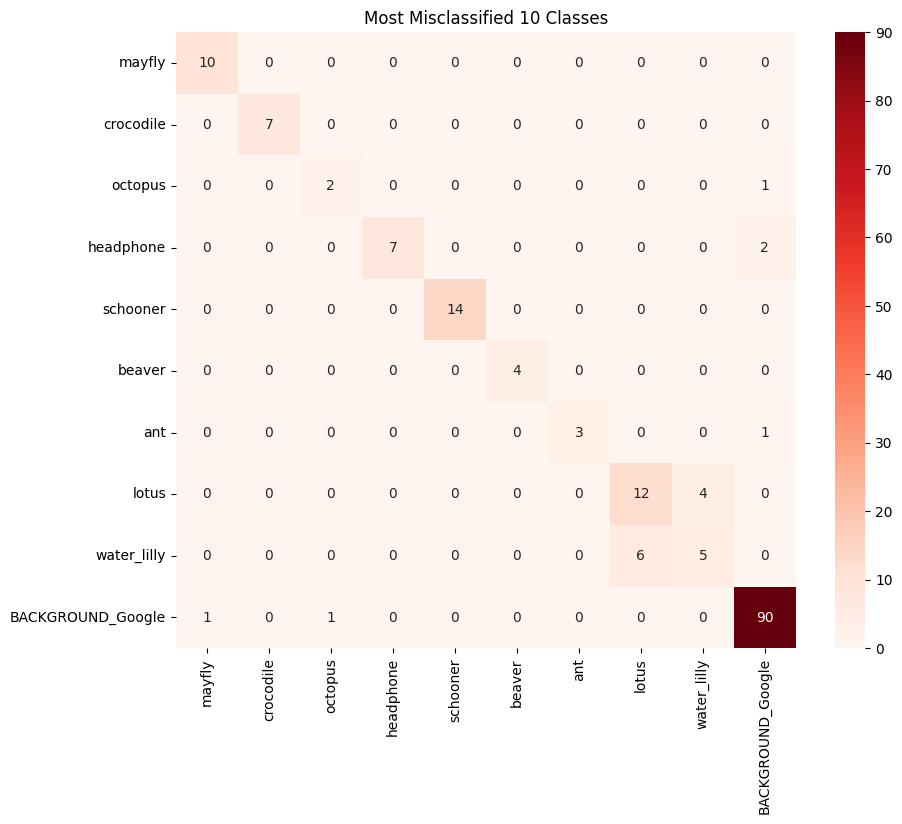

In [19]:
# Sum of wrong predictions per class
errors = np.sum(cm, axis=1) - np.diag(cm)
top_mis = np.argsort(errors)[-10:]  # Top 10 most confused classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm[np.ix_(top_mis, top_mis)],
            xticklabels=np.array(class_names)[top_mis],
            yticklabels=np.array(class_names)[top_mis],
            annot=True, cmap="Reds")
plt.title("Most Misclassified 10 Classes")
plt.show()


## Plot Loss & Accuracy Curves


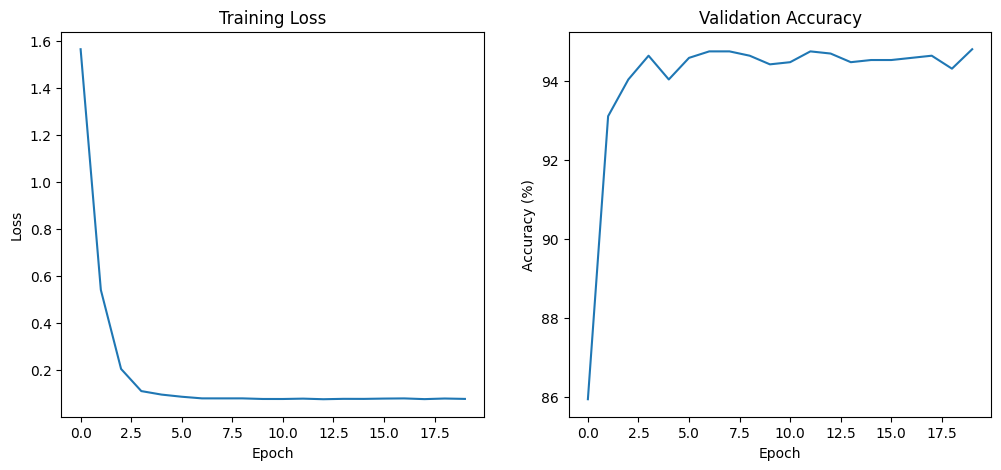

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

## Show Predictions on some test images


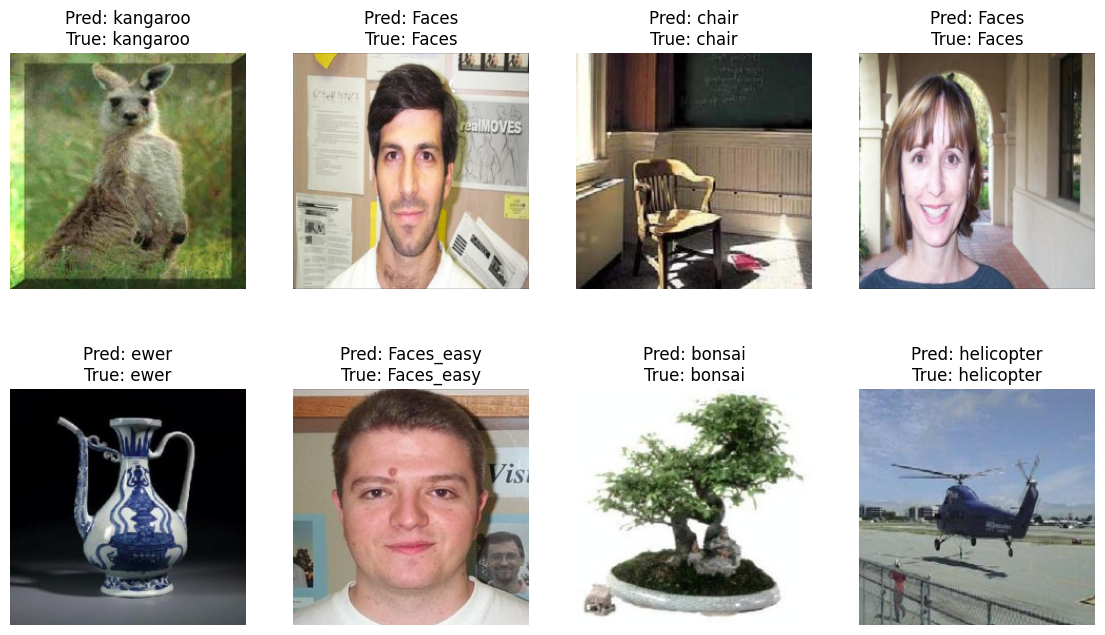

In [16]:
def show_predictions():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = outputs.max(1)
    
    plt.figure(figsize=(14, 8))
    for i in range(8):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {dataset.classes[preds[i]]}\nTrue: {dataset.classes[labels[i]]}")
        plt.axis('off')

    plt.show()

show_predictions()